In [53]:
def image_crop(file, image_width, image_height, cropped_width, cropped_height):
    cropped_images = []
    x = 0
    x_center = image_width // 2
    y_center = image_height // 2
    
    while x < image_width:
        y = 0
        while y < image_height:
            cropped_image = file[x : x + cropped_width, y : y + cropped_height]
            cropped_images.append(cropped_image)
            y += cropped_height
        x += cropped_width
    
    center_image = file[x_center - cropped_width // 2 : x_center + cropped_width // 2,
                       y_center - cropped_height // 2 : y_center + cropped_height // 2]
    
    cropped_images.append(center_image)
    
    return cropped_images

In [54]:
def data_generator(file, image_width, image_height):
    img_bgr = cv2.imread(file, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img_rgb, (image_width, image_height))

    return img

In [55]:
import cv2
import os, glob, numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf

def get_data(image_width, image_height):
    img_dir = './binary_cnn_majority/test'
    #categories = os.listdir(img_dir)
    categories = ['ad', 'non_ad']

    image_width = image_width # 사이즈 수정
    image_height = image_height

    X = []
    y = []
    X_original = []
    y_original = []
    index = []
    files = []
    filenames = []

    for i, category in enumerate(categories):
        img_detail = img_dir + '/' + category
        files.append(glob.glob(img_detail + "/*.jpg"))
        index.append(i)

    for file, i in zip(files, index):
        for f in file:
            img = data_generator(f, image_width, image_height)
            original_data = np.asarray(img)
            X_original.append(original_data)
            y_original.append(i)

            cropped_images = image_crop(img, image_width, image_height, image_width // 2, image_height // 2)

            for cropped_image in cropped_images:
                data = np.asarray(cropped_image)

                head, tail = os.path.split(f)
                filenames.append(tail)

                X.append(data)
                y.append(i)

    X = np.array(X)
    y = np.array(y)
    X_original = np.array(X_original)
    y_original = np.array(y_original)

    X = X.astype('float32') / 255

    print(len(X), len(y))
    print(len(X_original), len(y_original))
    
    return X, y, X_original, y_original

"""인자 바꾸기"""



'인자 바꾸기'

In [56]:
def print_scores(X, y, prediction):
    print('confusion matrix 결과')
    print(confusion_matrix(y, prediction, labels=[0, 1])) # 0 : 광고 1: 비광고

    print('precision 개별값')
    print(list(map('{:2.2f}%'.format, precision_score(y, prediction, average=None) * 100))) # precision 개별 값
    print('recall 개별값')
    print(list(map('{:2.2f}%'.format, recall_score(y, prediction, average=None) * 100)))

    #print('evaluate값')
    #print('{:2.2f}%'.format(model.evaluate(X, y)[1] * 100))
    
    print('f1 점수')
    print('{:2.2f}%'.format(f1_score(y, prediction, average='macro') * 100))

    print('precision 평균값')
    print('{:2.2f}%'.format(precision_score(y, prediction, average='macro') * 100)) # precision 평균 값
    
    print('recall 평균값')
    print('{:2.2f}%'.format(recall_score(y, prediction, average='macro') * 100))

In [57]:
import keras.backend.tensorflow_backend as K

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

"""수정 필요한 부분"""

# validation_rate = [0.05, 0.1, 0.15, 0.2]  # 리스트 바꾸기
# batch_list = [2, 4, 8]
# epochs = []
# Dropout = []
#model_layers = [2, 3, 4, 5, 6, 7, 8, 9, 10]

image_size = [120, 140, 160, 180, 200, 240, 280, 320]

model_evaluate = []
f1 = []
precision = []
recall = []

for size in image_size: #반복문 요소 바꾸기
    print('이미지 사이즈 : ' + str(size)) # 수정
    new_prediction = []    
    prediction = []
    X = []
    y = []
    X_original = []
    y_original = []
    
    X, y, X_original, y_original = get_data(size, size)
    model = load_model('./binary_cnn_majority/model/size/binary_model_saved' + str(size) + '.h5')
    ##############파일 인자 수정하기 ##############
    with K.tf_ops.device('/device:GPU:0'):
        prediction = model.predict(X)
        np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}) # 소수점 3자리까지
        
        count = []

        for p in prediction:
            is_ad = 0
            not_ad = 0
            amax = []

            count.append(p)

            if len(count) == 5:
                for c in count:
                    amax.append(c.round())
                    if c.round() == 0:
                        is_ad += 1
                    elif c.round() == 1:
                        not_ad += 1

                if is_ad > not_ad:
                    new_prediction.append(0)
                else:
                    new_prediction.append(1)

                count = []

            elif len(count) < 5:
                continue
    
    
    
    print('개별 결과')
    print(len(y), len(prediction))
    #print_scores(X, y, prediction)
    #model_evaluate.append(model.evaluate(X, y)[1] * 100)
    #precision.append(precision_score(y, prediction, average='macro') * 100)
    #recall.append(recall_score(y, prediction, average='macro') * 100)
    #f1.append(f1_score(y, prediction, average='macro') * 100)
    
    print('투표 결과')
    print(len(y_original), len(new_prediction))
    print_scores(X_original, y_original, new_prediction)
    #model_evaluate.append(model.evaluate(X_original, y_original)[1] * 100)
    precision.append(precision_score(y_original, new_prediction, average='macro') * 100)
    recall.append(recall_score(y_original, new_prediction, average='macro') * 100)
    f1.append(f1_score(y_original, new_prediction, average='macro') * 100)
    
"""수정 필요한 부분"""

이미지 사이즈 : 120
3195 3195
639 639
개별 결과
3195 3195
투표 결과
639 639
confusion matrix 결과
[[319   0]
 [279  41]]
precision 개별값
['53.34%', '100.00%']
recall 개별값
['100.00%', '12.81%']
f1 점수
46.14%
precision 평균값
76.67%
recall 평균값
56.41%
이미지 사이즈 : 140
3195 3195
639 639
개별 결과
3195 3195
투표 결과
639 639
confusion matrix 결과
[[219 100]
 [ 11 309]]
precision 개별값
['95.22%', '75.55%']
recall 개별값
['68.65%', '96.56%']
f1 점수
82.28%
precision 평균값
85.38%
recall 평균값
82.61%
이미지 사이즈 : 160
3195 3195
639 639
개별 결과
3195 3195
투표 결과
639 639
confusion matrix 결과
[[232  87]
 [  6 314]]
precision 개별값
['97.48%', '78.30%']
recall 개별값
['72.73%', '98.12%']
f1 점수
85.20%
precision 평균값
87.89%
recall 평균값
85.43%
이미지 사이즈 : 180
3195 3195
639 639
개별 결과
3195 3195
투표 결과
639 639
confusion matrix 결과
[[277  42]
 [ 23 297]]
precision 개별값
['92.33%', '87.61%']
recall 개별값
['86.83%', '92.81%']
f1 점수
89.82%
precision 평균값
89.97%
recall 평균값
89.82%
이미지 사이즈 : 200
3195 3195
639 639
개별 결과
3195 3195
투표 결과
639 639
confusion matrix 결과
[[101 218]
 [  4 316

C:\ProgramData\Anaconda3\envs\tensorflow-keras\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3195 3195
639 639
개별 결과
3195 3195
투표 결과
639 639
confusion matrix 결과
[[  0 319]
 [  0 320]]
precision 개별값
['0.00%', '50.08%']
recall 개별값
['0.00%', '100.00%']
f1 점수
33.37%
precision 평균값
25.04%
recall 평균값
50.00%
이미지 사이즈 : 320
3195 3195
639 639
개별 결과
3195 3195
투표 결과
639 639
confusion matrix 결과
[[ 17 302]
 [ 11 309]]
precision 개별값
['60.71%', '50.57%']
recall 개별값
['5.33%', '96.56%']
f1 점수
38.09%
precision 평균값
55.64%
recall 평균값
50.95%


'수정 필요한 부분'

In [58]:
#for i, pred in enumerate(prediction):
 #   if pred >= 0.5: print("해당 " + filenames[i] + "  이미지는 비광고 로 추정됩니다.")
  #  else : print("해당 " + filenames[i] + "  이미지는 광고 로 추정됩니다.")

'수정 필요한 부분'

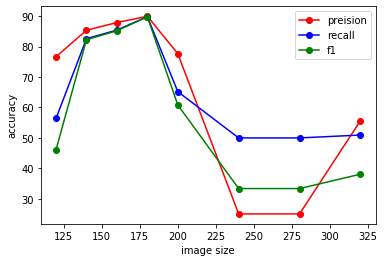

In [60]:
import matplotlib.pyplot as plt


"""수정 필요한 부분"""

plt.plot(image_size, precision, 'ro-', label='preision') # 리스트 수정
plt.plot(image_size, recall, 'bo-', label='recall')
plt.plot(image_size, f1, 'go-', label='f1')
#plt.plot(image_size, model_evaluate, 'yo-', label='evaluate')
plt.xlabel('image size') # xlabel 수정
plt.ylabel('accuracy')
plt.legend()

"""수정 필요한 부분"""